In [1]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
if device == 'cuda':
    torch.cuda.set_device(0)
    
    gpu_name = torch.cuda.get_device_name(0)
    torch.cuda.manual_seed_all(0)
    print(gpu_name, 'is Ready!')

GeForce RTX 2080 SUPER is Ready!


In [3]:
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [4]:
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [5]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [6]:
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [7]:
xy = pd.read_csv("GOOG.csv", delimiter=",")
xy = np.array(xy)
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)

testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

[[0.95724329 1.         0.97693104 1.         0.22399699]
 [0.9416674  0.94878891 0.95960238 0.93766521 0.17244047]
 [0.90401381 0.94047748 0.92311851 0.93131534 0.27845958]
 [0.93083954 0.9011709  0.88178638 0.87204982 0.34260208]
 [0.91896864 0.91342179 0.87252408 0.86959446 0.74961845]
 [0.92990754 0.95779312 0.94359998 0.95186769 0.5660973 ]
 [0.94521745 0.91478541 0.8773726  0.84241705 0.432711  ]] -> [0.20737597]
[[0.9416674  0.94878891 0.95960238 0.93766521 0.17244047]
 [0.90401381 0.94047748 0.92311851 0.93131534 0.27845958]
 [0.93083954 0.9011709  0.88178638 0.87204982 0.34260208]
 [0.91896864 0.91342179 0.87252408 0.86959446 0.74961845]
 [0.92990754 0.95779312 0.94359998 0.95186769 0.5660973 ]
 [0.94521745 0.91478541 0.8773726  0.84241705 0.432711  ]
 [0.88100466 0.88697221 0.89448389 0.88815731 0.20737597]] -> [0.1526625]
[[0.90401381 0.94047748 0.92311851 0.93131534 0.27845958]
 [0.93083954 0.9011709  0.88178638 0.87204982 0.34260208]
 [0.91896864 0.91342179 0.87252408 0.86

In [13]:
print(trainX_tensor.shape)
print(data_dim, hidden_dim, output_dim)

torch.Size([169, 7, 5])
5 10 1


In [9]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1).to(device)

In [10]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [17]:
import torchsummary

torchsummary.summary(net, (trainX_tensor.shape[1:]))

AttributeError: 'tuple' object has no attribute 'size'

In [14]:
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.15940462052822113
1 0.10946325957775116
2 0.07281270623207092
3 0.04686705395579338
4 0.029827162623405457
5 0.0205968227237463
6 0.018263639882206917
7 0.02104717120528221
8 0.025570647791028023
9 0.028774447739124298
10 0.02956036664545536
11 0.02824566885828972
12 0.025677653029561043
13 0.022708900272846222
14 0.019973149523139
15 0.017833009362220764
16 0.0164142157882452
17 0.01567457802593708
18 0.01547607034444809
19 0.01564369536936283
20 0.01600583828985691
21 0.016417600214481354
22 0.016771309077739716
23 0.016998451203107834
24 0.017066534608602524
25 0.016973193734884262
26 0.016739076003432274
27 0.016400424763560295
28 0.016001887619495392
29 0.015589877963066101
30 0.015206778421998024
31 0.014886235818266869
32 0.014649846591055393
33 0.014505503699183464
34 0.014447624795138836
35 0.014459250494837761
36 0.014515755698084831
37 0.014589552767574787
38 0.01465495303273201
39 0.014692257158458233
40 0.014690328389406204
41 0.014647267758846283
42 0.0145692601799964

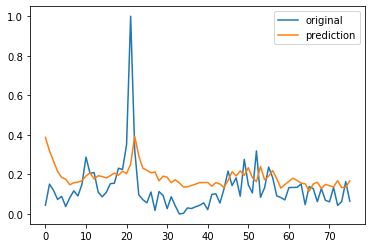

In [15]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.cpu().numpy())
plt.legend(['original', 'prediction'])
plt.show()